In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
store_sales = pd.read_csv("train.csv")
store_sales.head(10)                        

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


Check for null values in the dataset

In [4]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Dropping store and item column

In [5]:
store_sales = store_sales.drop(['store','item'], axis=1)

In [6]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


Converting date datatype from obj to datetime

In [7]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [8]:
store_sales.info()
store_sales.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10
5,2013-01-06,12
6,2013-01-07,10
7,2013-01-08,9
8,2013-01-09,12
9,2013-01-10,9


Converting date to a Month period, and then sum the nmber of items in each month

In [9]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()
monthly_sales.head(20)

,date,sales
0,2013-01,454904
1,2013-02,459417
2,2013-03,617382
3,2013-04,682274
4,2013-05,763242
5,2013-06,795597
6,2013-07,855922
7,2013-08,766761
8,2013-09,689907
9,2013-10,656587


Convert the resulting date column to timestamp datatype

In [10]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


In [11]:
monthly_sales.shape

(60, 2)

Visualiztion

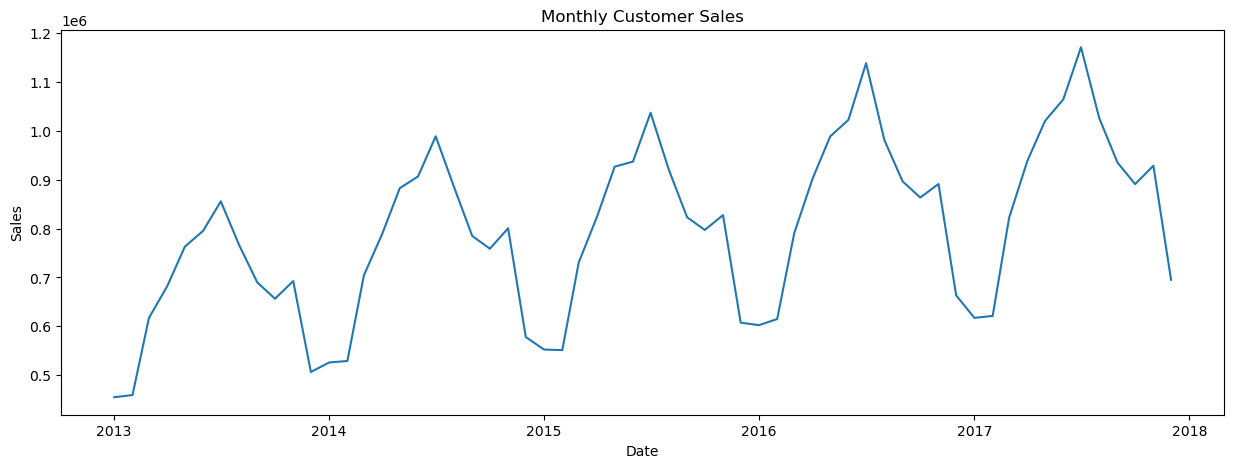

In [12]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales")
plt.show()

Call the difference on the sales col to make the sales data stationary

In [13]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna() #to remove the null value from the dataframe object
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


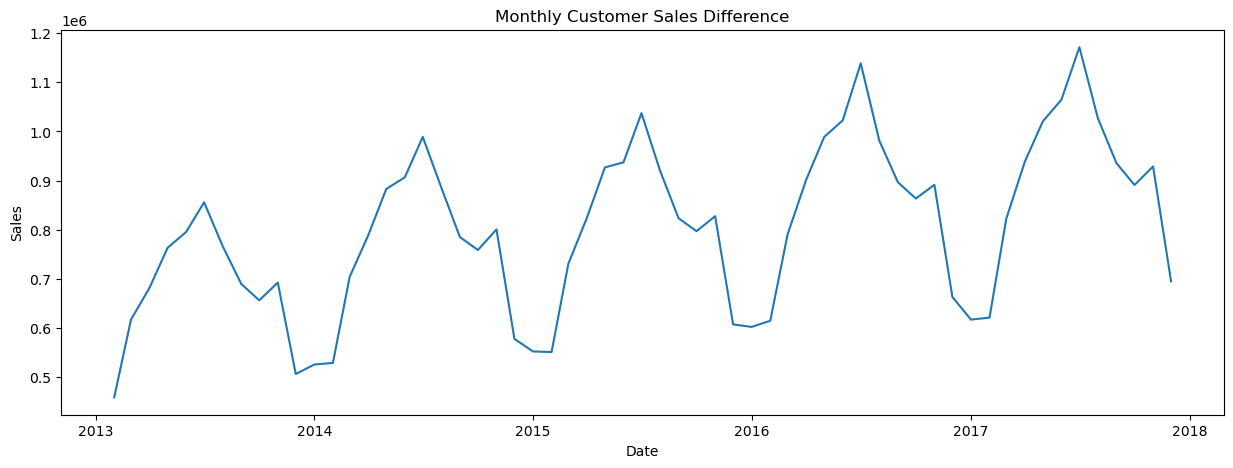

In [14]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales Difference")
plt.show()

Dropping off sales and date

In [15]:
supervised_data = monthly_sales.drop(['date' ,'sales'], axis=1)

Preparing the supervised data

In [16]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(60)


,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Split the data into Train and test

In [17]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)



Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [18]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [19]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train Shape: ", x_train.shape)
print("y_train Shape: ", y_train.shape)
print("x_test Shape: ", x_test.shape)
print("X_test Shape: ", y_test.shape)

x_train Shape:  (35, 12)
y_train Shape:  (35,)
x_test Shape:  (12, 12)
X_test Shape:  (12,)


Make prediction data frame to merge the predicted sales price of all trained algs

In [20]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)


In [21]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


To create linear regression model, and prdicted output 

In [22]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)

In [23]:
lr_pre = lr_pre.reshape(-1,1)
# This is a set matrix - contains the input feature of test data and also the predicted output
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [24]:
result_list =[]
for index in range (0, len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [25]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])

print("Linear Regression MSE:", lr_mse)
print("Linear Regression MAE:", lr_mae)
print("Linear Regression R2:", lr_r2)

Linear Regression MSE: 16221.272385416902
Linear Regression MAE: 12433.184266490745
Linear Regression R2: 0.9906152516380968


In [27]:
import joblib
joblib.dump(lr_model, "model.pkl")

['model.pkl']

Visualization of the prediction against actual sales

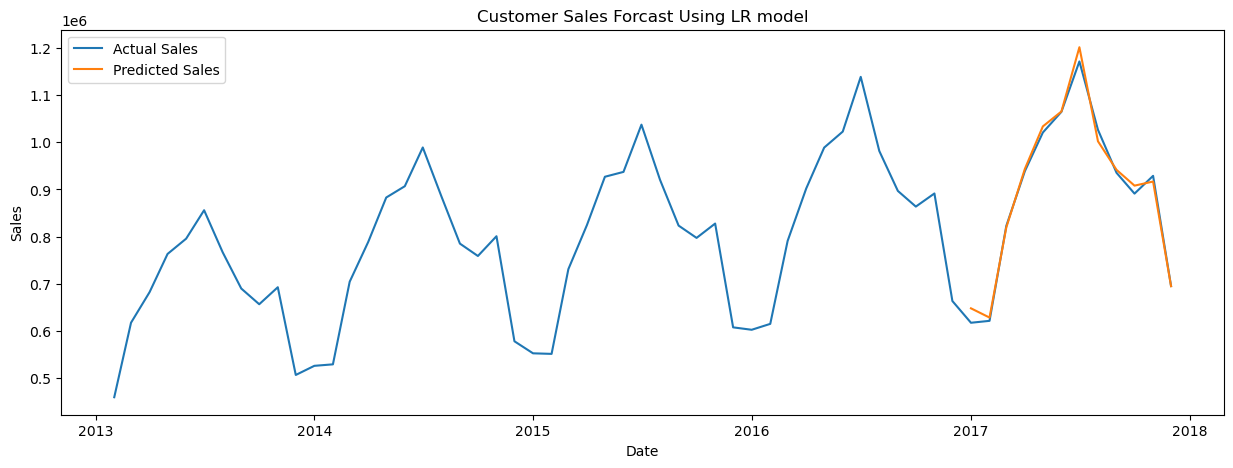

In [26]:
plt.figure(figsize=(15,5))
#Actual Sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer Sales Forcast Using LR model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])

In [28]:
x_test

array([[-1.02635392,  0.24535439, -0.05787474, -0.31370458, -0.67437352,
         0.68397168,  0.27578914,  0.53846345,  0.65919343,  0.98155922,
         0.16933959,  0.0816042 ],
       [-0.12204966, -1.02635392,  0.24535439, -0.05787474, -0.31370458,
        -0.67437352,  0.68397168,  0.27578914,  0.53846345,  0.65919343,
         0.98155922,  0.16933959],
       [ 0.12731349, -0.12204966, -1.02635392,  0.24535439, -0.05787474,
        -0.31370458, -0.67437352,  0.68397168,  0.27578914,  0.53846345,
         0.65919343,  0.98155922],
       [ 1.10768225,  0.12731349, -0.12204966, -1.02635392,  0.24535439,
        -0.05787474, -0.31370458, -0.67437352,  0.68397168,  0.27578914,
         0.53846345,  0.65919343],
       [ 0.68467253,  1.10768225,  0.12731349, -0.12204966, -1.02635392,
         0.24535439, -0.05787474, -0.31370458, -0.67437352,  0.68397168,
         0.27578914,  0.53846345],
       [ 0.51382935,  0.68467253,  1.10768225,  0.12731349, -0.12204966,
        -1.02635392,  

In [30]:
y_test

array([-0.10745675,  0.13866328,  1.10628178,  0.68877355,  0.52015228,
        0.33428672,  0.64253037, -0.59257833, -0.32839471, -0.0976351 ,
        0.30357077, -1.02762031])